In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("analisis_elecciones").getOrCreate()

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import sum
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30)
sns.set()

---
# Dataset Elecciones PASO 2023

In [4]:
paso_original = spark.read.csv('ResultadosElectorales_PASO.csv', header=True, inferSchema=True)
paso = paso_original

In [5]:
paso.show(5)

+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
| año|eleccion_tipo|recuento_tipo|padron_tipo|distrito_id|distrito_nombre|seccionprovincial_id|seccionprovincial_nombre|seccion_id|seccion_nombre|circuito_id|circuito_nombre|mesa_id|mesa_tipo|mesa_electores|cargo_id|cargo_nombre|agrupacion_id|   agrupacion_nombre|lista_numero|        lista_nombre|votos_tipo|votos_cantidad|
+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
|2023|         PASO|   PR

In [6]:
partidos = [
    'NULO',
    'JUNTOS POR EL CAMBIO',
    'HACEMOS POR NUESTRO PAIS',
    'LA LIBERTAD AVANZA',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD',
    'UNION POR LA PATRIA'
]

# Los espacion None los relleno con NULO
paso = paso.fillna({'agrupacion_nombre':'NULO'})

# Me dejo los registros unicamente si la agrupacón esta dentro de los 5 partidos principales y que sean cargos de PRESIDENTE
paso_filtered = paso.filter((paso["agrupacion_nombre"].isin(partidos)) & (paso['cargo_nombre'] == 'PRESIDENTE/A'))

In [7]:
# Comprobación de que no hay mas nulos
paso.filter(paso['agrupacion_nombre'].isNull()).count()

0

In [8]:
cantidad_votos_provincia_paso = paso_filtered.groupBy(
    ['distrito_nombre', 'agrupacion_nombre']).sum().select(
        ['distrito_nombre','agrupacion_nombre','sum(votos_cantidad)'])

cantidad_votos_provincia_paso = cantidad_votos_provincia_paso.toPandas()

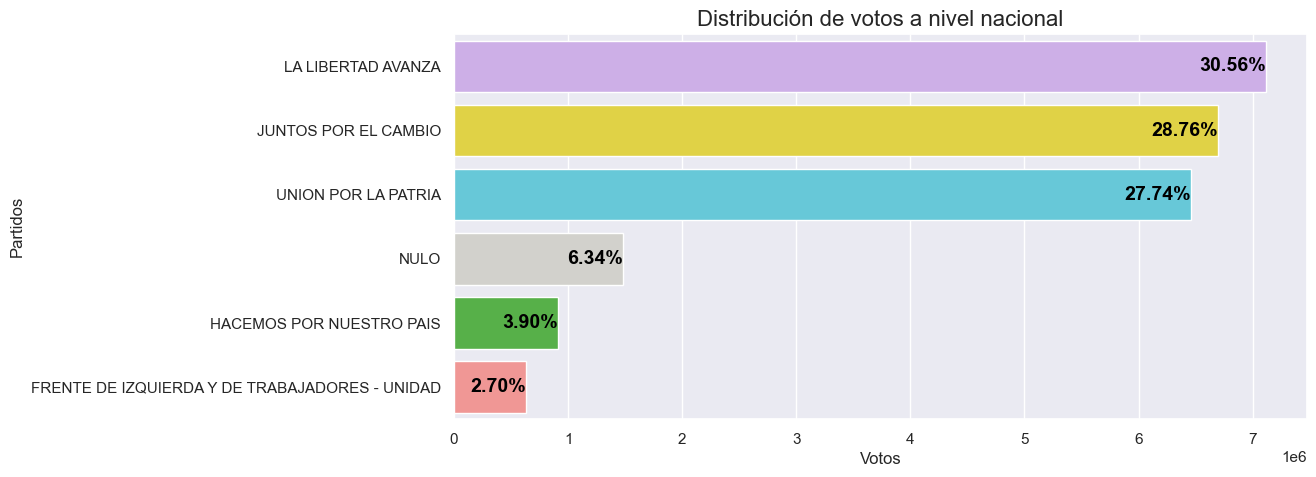

In [9]:
plt.figure(figsize=(11,5))

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Calcula los porcentajes
data = cantidad_votos_provincia_paso.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


ax = sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette)

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    ax.text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.title('Distribución de votos a nivel nacional', fontsize=16)
plt.xlabel('Votos')
plt.ylabel('Partidos')
plt.show()

### Distribución de votos en las 5 provincias principales del pais.

In [10]:
cantidad_votos_provincia_paso.groupby(['distrito_nombre']).sum().sort_values(by=['sum(votos_cantidad)'], ascending=False).head(5)

,agrupacion_nombre,sum(votos_cantidad)
distrito_nombre,,
Buenos Aires,UNION POR LA PATRIANULOFRENTE DE IZQUIERDA Y D...,8623697
Córdoba,UNION POR LA PATRIAJUNTOS POR EL CAMBIOLA LIBE...,2033781
Santa Fe,JUNTOS POR EL CAMBIOUNION POR LA PATRIANULOLA ...,1825910
Ciudad Autónoma de Buenos Aires,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD...,1648396
Mendoza,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD...,1019805


In [11]:
provincias_principales = cantidad_votos_provincia_paso.groupby(['distrito_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index().distrito_nombre.head(5).to_list()
provincias_principales

['Buenos Aires',
 'Córdoba',
 'Santa Fe',
 'Ciudad Autónoma de Buenos Aires',
 'Mendoza']

In [12]:
cantidad_votos_provincia_paso[cantidad_votos_provincia_paso['distrito_nombre'].isin(provincias_principales)].groupby(['distrito_nombre','agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False)

sum(votos_cantidad)
distrito_nombre                 agrupacion_nombre                                                  
Buenos Aires                    UNION POR LA PATRIA                                         2831078
                                JUNTOS POR EL CAMBIO                                        2567840
                                LA LIBERTAD AVANZA                                          2161679
Ciudad Autónoma de Buenos Aires JUNTOS POR EL CAMBIO                                         813264
Córdoba                         LA LIBERTAD AVANZA                                           688684
Buenos Aires                    NULO                                                         671913
Santa Fe                        LA LIBERTAD AVANZA                                           646315
                                JUNTOS POR EL CAMBIO                                         579867
Córdoba                         HACEMOS POR NUESTRO PAIS                                     564182
                                JUNTOS POR EL CAMBIO                                         515456
Mendoza                         LA LIBERTAD AVANZA                                           466437
Ciudad Autónoma de Buenos Aires UNION POR LA PATRIA                                          397054
Santa Fe                        UNION POR LA PATRIA                                          386865
Ciudad Autónoma de Buenos Aires LA LIBERTAD AVANZA                                           299097
Mendoza                         JUNTOS POR EL CAMBIO                                         294077
Buenos Aires                    FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD               293601
Córdoba                         UNION POR LA PATRIA                                          177528
Mendoza                         UNION POR LA PATRIA                                          175522
Santa Fe                        NULO                                                         114455
Buenos Aires                    HACEMOS POR NUESTRO PAIS                                      97586
Ciudad Autónoma de Buenos Aires FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                78014
Santa Fe                        HACEMOS POR NUESTRO PAIS                                      67563
Córdoba                         NULO                                                          56796
Ciudad Autónoma de Buenos Aires NULO                                                          45081
Mendoza                         NULO                                                          38459
                                FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                31452
Córdoba                         FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                31135
Santa Fe                        FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                30845
Ciudad Autónoma de Buenos Aires HACEMOS POR NUESTRO PAIS                                      15886
Mendoza                         HACEMOS POR NUESTRO PAIS                                      13858

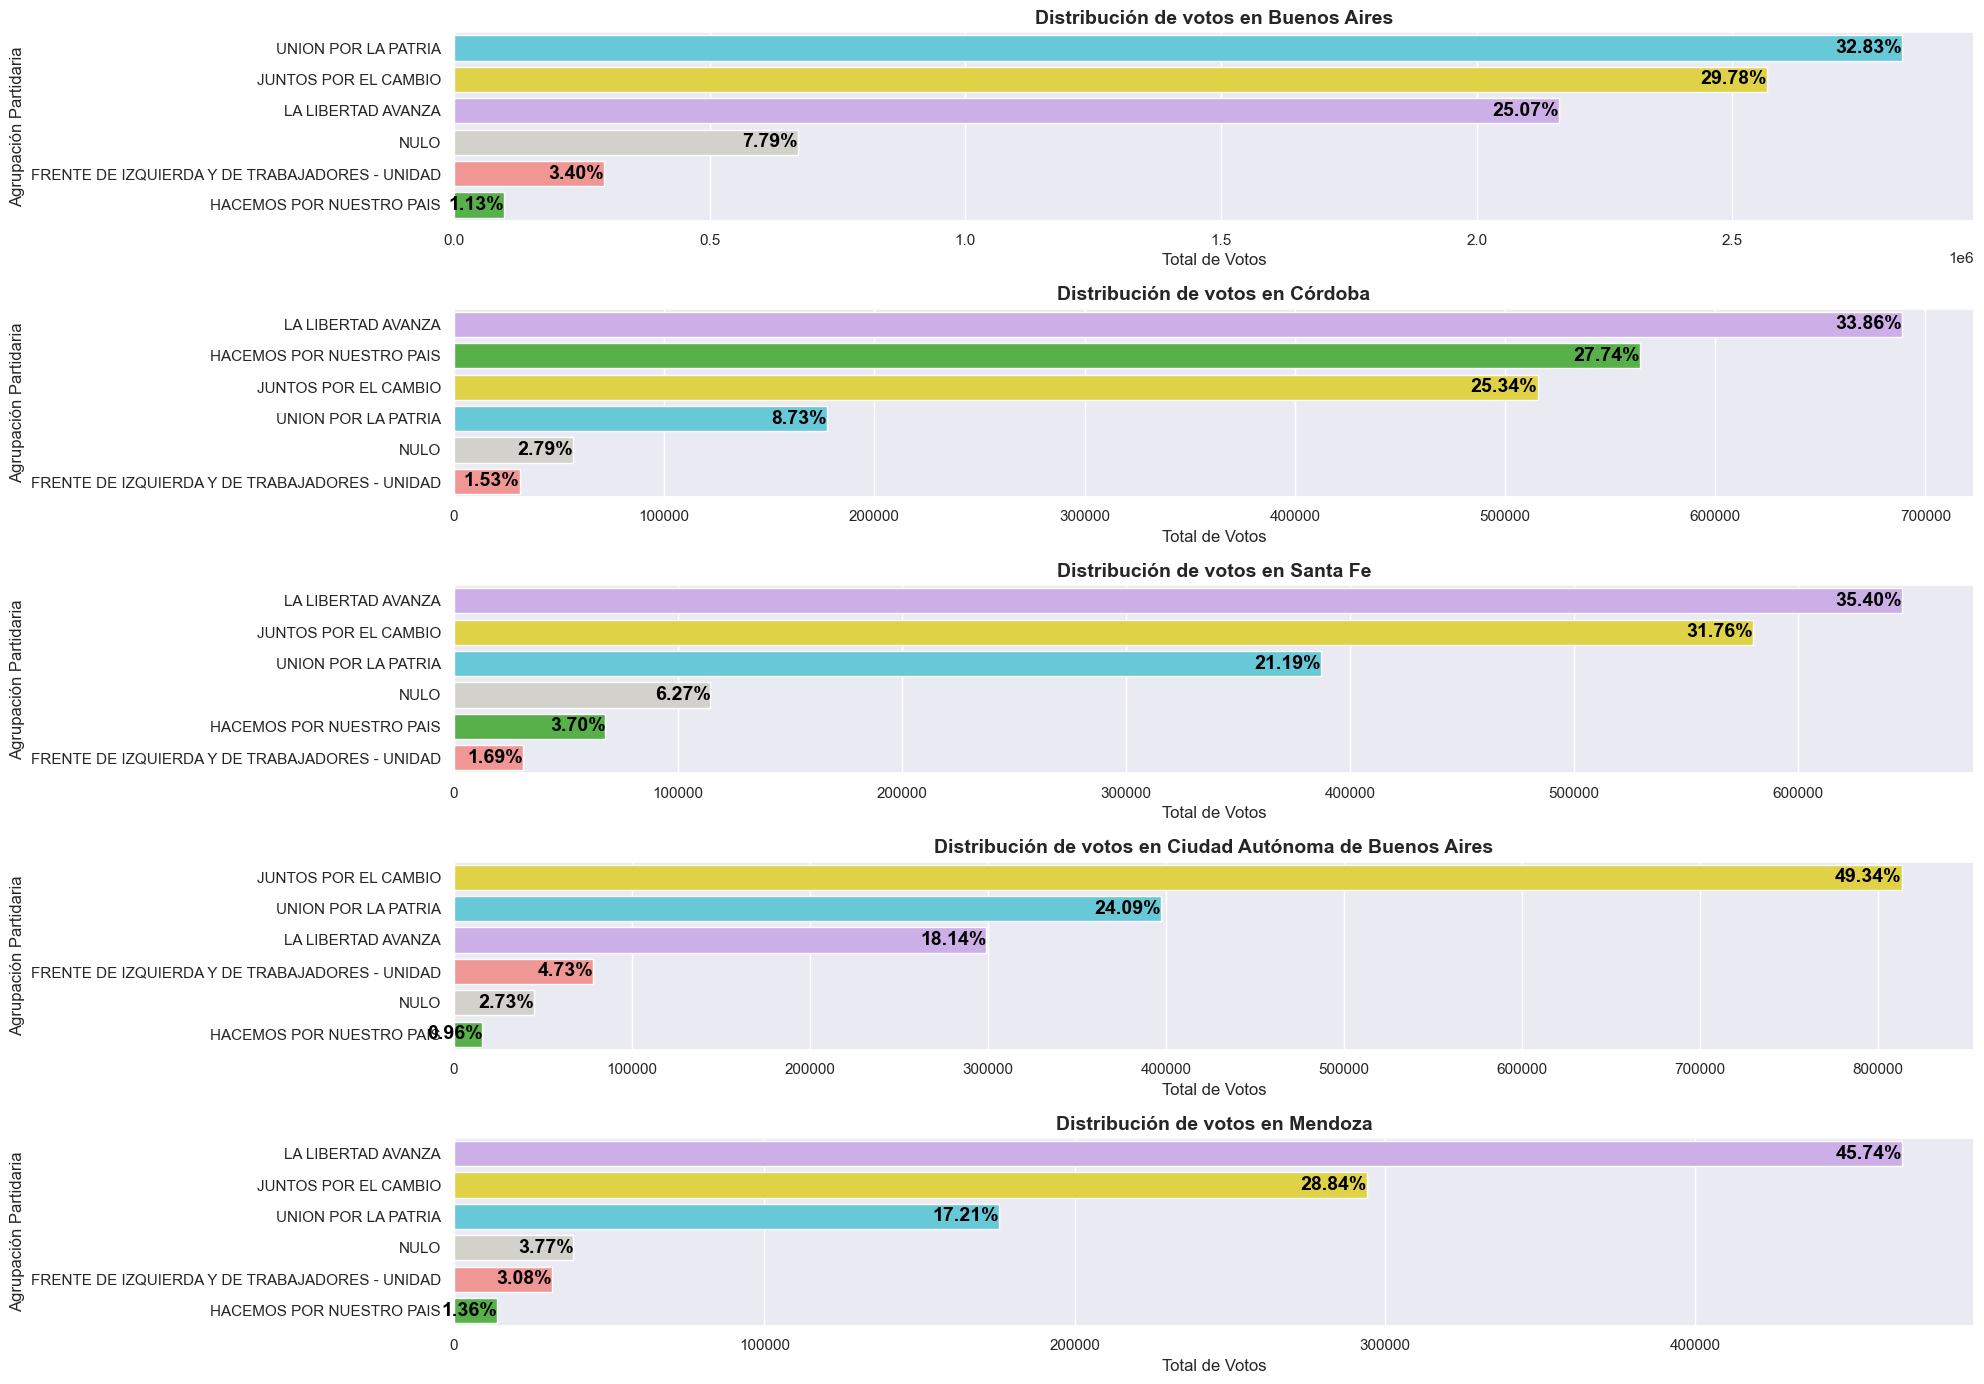

In [15]:

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Crea una figura con 5 subplots apilados verticalmente
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 14))

for index, p in enumerate(provincias_principales):
    # Filtra los datos para la provincia actual
    data = cantidad_votos_provincia_paso[cantidad_votos_provincia_paso['distrito_nombre'] == p]

    # Agrupa los datos por distrito y agrupación política y suma los votos
    d = data.groupby(['distrito_nombre', 'agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
    total_votos_provincia = d['sum(votos_cantidad)'].sum()
    d['porcentaje'] = round((d['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

    sns.barplot(data=d, x='sum(votos_cantidad)', y='agrupacion_nombre', ax=axes[index], palette=palette)

    # Configura títulos y etiquetas si es necesario
    axes[index].set_title(f'Distribución de votos en {p}', fontsize=14, weight='bold')
    axes[index].set_xlabel('Total de Votos')
    axes[index].set_ylabel('Agrupación Partidaria')

    for i, row in d.iterrows():
        porcentaje = row['porcentaje']
        axes[index].text(row['sum(votos_cantidad)'], i, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.tight_layout()
plt.show()

Diferencia entre las PASO con las GENERALES

In [155]:
cantidad_votos_provincia_paso

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad),porcentaje
0,Buenos Aires,UNION POR LA PATRIA,2831078,12.16
1,Salta,JUNTOS POR EL CAMBIO,111009,0.48
2,Salta,UNION POR LA PATRIA,155837,0.67
3,Santiago del Estero,UNION POR LA PATRIA,280563,1.20
4,Santiago del Estero,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,5606,0.02
...,...,...,...,...
139,"Tierra del Fuego, Antártida e Islas del Atlánt...",HACEMOS POR NUESTRO PAIS,4315,0.02
140,"Tierra del Fuego, Antártida e Islas del Atlánt...",NULO,7124,0.03
141,"Tierra del Fuego, Antártida e Islas del Atlánt...",FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,2703,0.01
142,"Tierra del Fuego, Antártida e Islas del Atlánt...",UNION POR LA PATRIA,29600,0.13


In [152]:
d# Agrupa los datos por distrito y agrupación política y suma los votos
d = data.groupby(['distrito_nombre', 'agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = d['sum(votos_cantidad)'].sum()
d['porcentaje'] = round((d['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)
d

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad),porcentaje
0,Mendoza,LA LIBERTAD AVANZA,466437,45.74
1,Mendoza,JUNTOS POR EL CAMBIO,294077,28.84
2,Mendoza,UNION POR LA PATRIA,175522,17.21
3,Mendoza,NULO,38459,3.77
4,Mendoza,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,31452,3.08
5,Mendoza,HACEMOS POR NUESTRO PAIS,13858,1.36


---
# Dataset Elecciones GENERALES 2023

In [16]:
df_generales = spark.read.csv("ResultadosElectorales_2023_Generales.csv", header=True, inferSchema=True)

Me quedo unicamente con los datos de PRESIDENTE Y VICEPRESIDENTE

In [17]:
partidos = [
    'NULO',
    'JUNTOS POR EL CAMBIO',
    'HACEMOS POR NUESTRO PAIS',
    'LA LIBERTAD AVANZA',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD',
    'UNION POR LA PATRIA'
]

# Los espacion None los relleno con NULO
df_generales = df_generales.fillna({'agrupacion_nombre':'NULO'})

# Me dejo los registros unicamente si la agrupacón esta dentro de los 5 partidos principales y que sean cargos de PRESIDENTE
df_generales_filtered = df_generales.filter((df_generales["agrupacion_nombre"].isin(partidos)) & (df_generales['cargo_nombre'] == 'PRESIDENTE Y VICE'))

In [18]:
df_generales_filtered.sample(False, 0.0010, seed=123).show()

+----+-------------+-------------+-----------+-----------+--------------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+-----------------+-------------+--------------------+------------+------------+----------+--------------+
| año|eleccion_tipo|recuento_tipo|padron_tipo|distrito_id|     distrito_nombre|seccionprovincial_id|seccionprovincial_nombre|seccion_id|seccion_nombre|circuito_id|circuito_nombre|mesa_id|mesa_tipo|mesa_electores|cargo_id|     cargo_nombre|agrupacion_id|   agrupacion_nombre|lista_numero|lista_nombre|votos_tipo|votos_cantidad|
+----+-------------+-------------+-----------+-----------+--------------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+-----------------+-------------+--------------------+------------+------------+----------+--------------+
|2023|      GENERAL

In [29]:
cantidad_votos_provincia_generales = df_generales_filtered.groupBy(
    ['distrito_nombre', 'agrupacion_nombre']).sum().select(
        ['distrito_nombre','agrupacion_nombre','sum(votos_cantidad)'])

cantidad_votos_provincia_generales = cantidad_votos_provincia_generales.toPandas()

In [31]:
cantidad_votos_provincia_generales.sample(5)

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad)
54,La Rioja,HACEMOS POR NUESTRO PAIS,20179
93,La Pampa,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,5244
78,La Pampa,UNION POR LA PATRIA,79229
122,Santa Cruz,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,4948
84,Chaco,NULO,12966


In [22]:
generales = df_generales_filtered.toPandas()

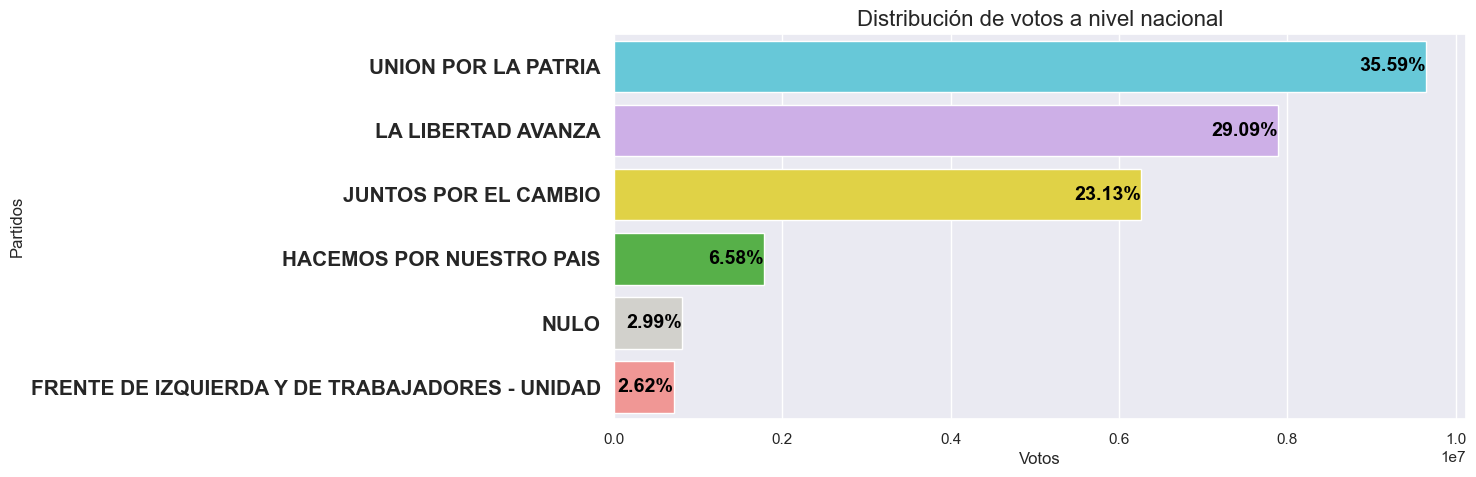

In [34]:
plt.figure(figsize=(11,5))

data = cantidad_votos_provincia_generales.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


ax = sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette)

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    ax.text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.title('Distribución de votos a nivel nacional', fontsize=16)
plt.xlabel('Votos')
plt.ylabel('Partidos')
plt.yticks(fontsize=15, weight='bold')
plt.show()

### Comparacion de elecciones PASO y GENERALES

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

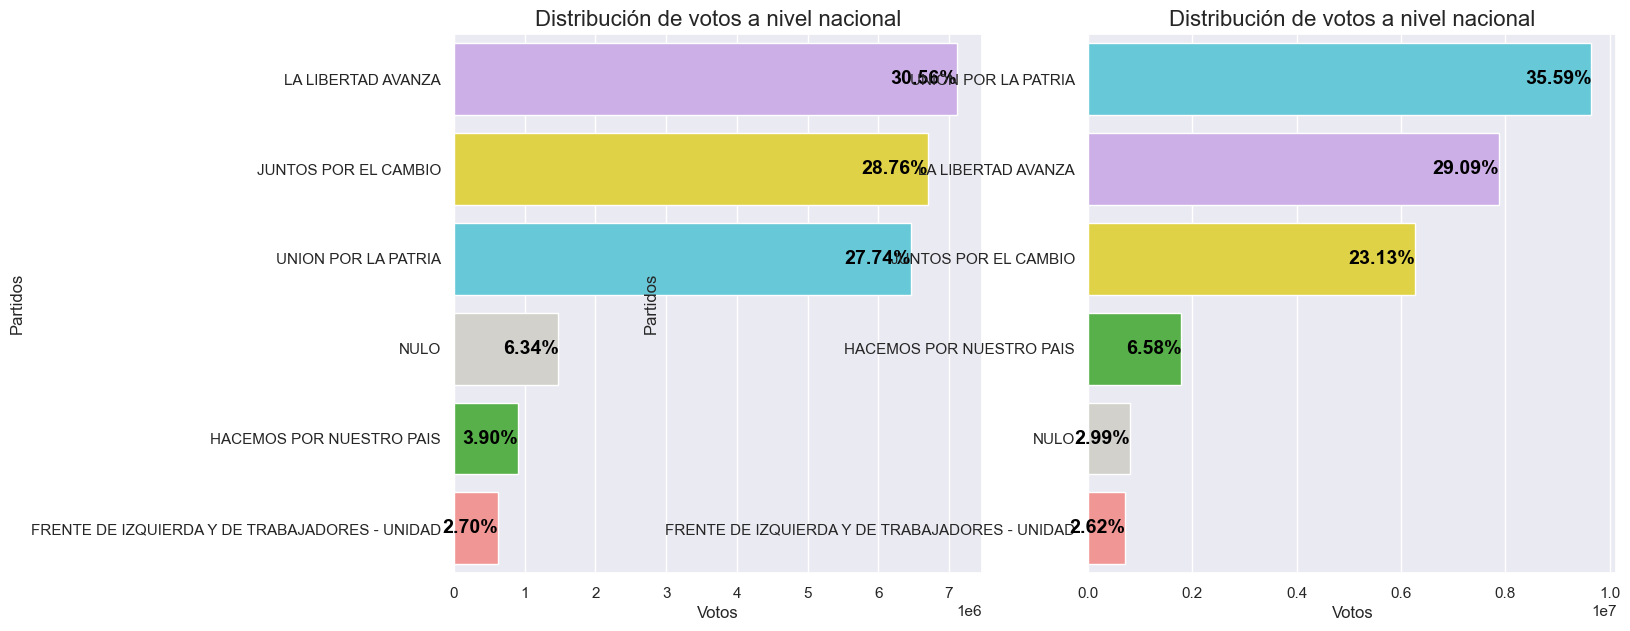

In [35]:
fig , axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Calcula los porcentajes
data = cantidad_votos_provincia_paso.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette,
            ax=axes[0])

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[0].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

axes[0].set_title('Distribución de votos a nivel nacional', fontsize=16)
axes[0].set_xlabel('Votos')
axes[0].set_ylabel('Partidos')

data = cantidad_votos_provincia_generales.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette,
            ax=axes[1])

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[1].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

axes[1].set_title('Distribución de votos a nivel nacional', fontsize=16)
axes[1].set_xlabel('Votos')
axes[1].set_ylabel('Partidos')
axes[1].set_yticks(fontsize=15, weight='bold')

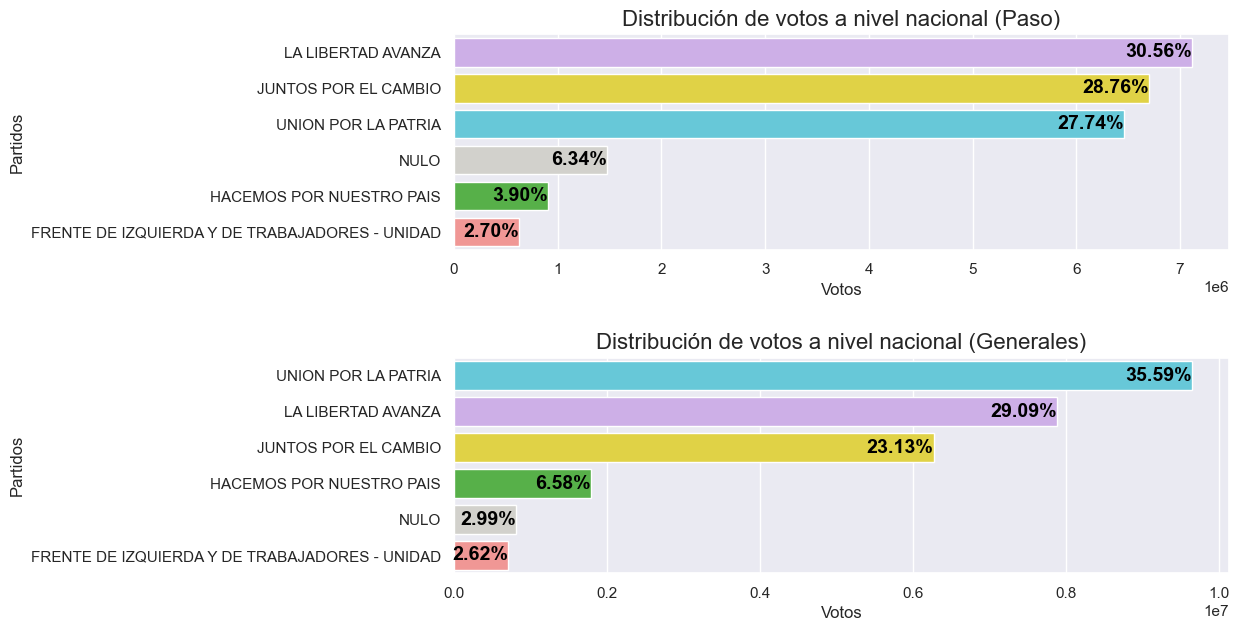

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plt.subplots_adjust(hspace=0.5)

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Calcula los porcentajes para el primer gráfico
data = cantidad_votos_provincia_paso.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

# Primer gráfico
sns.barplot(data=data,
            x='sum(votos_cantidad)',
            y='agrupacion_nombre',
            errorbar=None,
            palette=palette,
            ax=axes[0])

# Agrega los porcentajes en las barras del primer gráfico
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[0].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right', va='center', fontsize=14, color='black', weight='bold')

axes[0].set_title('Distribución de votos a nivel nacional (Paso)', fontsize=16)
axes[0].set_xlabel('Votos')
axes[0].set_ylabel('Partidos')

# Calcula los porcentajes para el segundo gráfico
data = cantidad_votos_provincia_generales.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

# Segundo gráfico
sns.barplot(data=data,
            x='sum(votos_cantidad)',
            y='agrupacion_nombre',
            errorbar=None,
            palette=palette,
            ax=axes[1])

# Agrega los porcentajes en las barras del segundo gráfico
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[1].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right', va='center', fontsize=14, color='black', weight='bold')

axes[1].set_title('Distribución de votos a nivel nacional (Generales)', fontsize=16)
axes[1].set_xlabel('Votos')
axes[1].set_ylabel('Partidos')

plt.show()